<a href="https://colab.research.google.com/github/thanhnguyen2612/diveintocode-ml/blob/master/ML_sprint11_Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Convolutional 1D

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## [Problem 1] Creating a one-dimensional convolutional layer class that limits the number of channels to one

In [59]:
def forward(X, W, B):
    a = []
    for i in range(len(X) - len(W) + 1):
        a.append(np.sum(X[i:i + len(W)] * W) + B)
    return np.array(a)

def backward(X, W, dA):
    dB = np.sum(dA)

    dW = np.zeros(len(W))
    for i in range(len(W)):
        dW[i] = np.sum(X[i:i+len(dA)] * dA)

    zero = np.zeros(len(dA) - 1)
    padding_W = np.concatenate([zero, W, zero], axis=0)
    dX = np.zeros(len(X))
    for i in range(len(X)):
        dX[i] = np.sum(padding_W[i:i+len(dA)] * dA[::-1])

    return dW, dB, dX

## [Problem 2] Output size calculation after one-dimensional convolution

In [60]:
def output_shape(n_in, filter_size, padding_size=0, stride_size=1):
    return int((n_in + 2 * padding_size - filter_size) / stride_size + 1)

## [Problem 3] Experiment of one-dimensional convolutional layer with small array

In [61]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = 1

In [62]:
output_shape(4, 3, 0, 1)

2

In [63]:
forward(x, w, b)

array([35, 50])

In [64]:
delta_a = np.array([10, 20])
backward(x, w, delta_a)

(array([ 50.,  80., 110.]), 30, array([ 30., 110., 170., 140.]))

## [Problem 4] Creating a one-dimensional convolutional layer class that does not limit the number of channels

In [65]:
# Shape (2, 4): (number of input channels, number of features)
X = np.array([[1, 2, 3, 4],
              [2, 3, 4, 5]])

# Shape: (number of output channels, number of input channels, filter_size)
W = np.array([[[1, 1, 2],
               [2, 1, 1]],
              [[2, 1, 1],
               [1, 1, 1]],
              [[1, 1, 1],
               [1, 1, 1]]])

# Shape: (number of output channels)
B = np.array([1, 2, 3])

In [66]:
# Forward
def forward_channels(X, W, B):
    out_feature_size = output_shape(X.shape[1], W.shape[2])
    A = np.zeros((W.shape[0], out_feature_size))

    for out_channel in range(W.shape[0]):
        for in_channel in range(W.shape[1]):
            for i in range(out_feature_size):
                A[out_channel, i] += np.sum(X[in_channel, i:i + W.shape[2]] * W[out_channel, in_channel, :])

    A += B[:, np.newaxis]
    return A

def backward_channels(X, W, B, dA):
    dB = np.sum(dA, axis=1)

    dW = np.zeros(W.shape)
    for out_channel in range(W.shape[0]):
        for in_channel in range(W.shape[1]):
            for fs in range(W.shape[2]):
                dW[out_channel, in_channel, fs] += np.sum(X[in_channel, fs:fs + dA.shape[1]] * dA[out_channel])
    
    dX = np.zeros(X.shape)
    for out_channel in range(W.shape[0]):
        for in_channel in range(W.shape[1]):
            for fs in range(W.shape[2]):
                for m in range(dA.shape[1]):
                    dX[in_channel, fs + m] += W[out_channel, in_channel, fs] * dA[out_channel, m]
    
    return dW, dB, dX

In [67]:
forward_channels(X, W, B)

array([[21., 29.],
       [18., 25.],
       [18., 24.]])

In [68]:
# Backward
dA = np.array([[9, 11],
               [32, 35],
               [52, 56]])
backward_channels(X, W, B, dA)

(array([[[ 31.,  51.,  71.],
         [ 51.,  71.,  91.]],
 
        [[102., 169., 236.],
         [169., 236., 303.]],
 
        [[164., 272., 380.],
         [272., 380., 488.]]]),
 array([ 20,  67, 108]),
 array([[125., 230., 204., 113.],
        [102., 206., 195., 102.]]))

## [Problem 5] (Advanced task) Implementing padding

In [69]:
def zero_padding(X, padding_size=0):
    return np.pad(X, padding_size, "constant")

In [70]:
zero_padding([1, 2, 3, 4, 5], 1)

array([0, 1, 2, 3, 4, 5, 0])

In [71]:
a = [[1, 2, 3],
     [4, 5, 6]]
zero_padding(a, 2)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 2, 3, 0, 0],
       [0, 0, 4, 5, 6, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

## [Problem 7] (Advance assignment) Arbitrary number of strides

In [72]:
# Forward
def forward_2(X, W, B, padding_size=0, stride_size=1):
    out_feature_size = output_shape(X.shape[1], W.shape[2], padding_size, stride_size)
    A = np.zeros((W.shape[0], out_feature_size))

    for out_channel in range(W.shape[0]):
        for in_channel in range(W.shape[1]):
            for i in range(0, out_feature_size):
                pad_X = np.pad(X[in_channel], padding_size)
                idx = i * stride_size
                A[out_channel, i] += np.sum(pad_X[idx:idx + W.shape[2]] * W[out_channel, in_channel, :])

    A += B[:, None]
    return A

def backward_2(X, W, B, dA, padding_size=0, stride_size=1):
    dB = np.sum(dA, axis=1)

    dW = np.zeros(W.shape)
    dX = np.zeros((*X.shape[:-1], X.shape[-1] + 2*padding_size))
    for out_chn in range(W.shape[0]):
        for in_chn in range(W.shape[1]):
            for fs in range(W.shape[2]):
                for i in range(dA.shape[1]):
                    pad_X = np.pad(X[in_chn], padding_size)
                    dW[out_chn, in_chn, fs] += pad_X[fs + i*stride_size] * dA[out_chn, i]
                    dX[in_chn, fs + i*stride_size] += W[out_chn, in_chn, fs] * dA[out_chn, i]

    if padding_size > 0:
        dX = dX[:, padding_size:-padding_size]
    return dW, dB, dX

In [73]:
X = np.array([[1, 2, 3, 4],
              [2, 3, 4, 5]])

W = np.array([[[1, 1, 2],
               [2, 1, 1]],
              [[2, 1, 1],
               [1, 1, 1]],
              [[1, 1, 1],
               [1, 1, 1]]])

B = np.array([1, 2, 3])

dA = np.array([[9, 11, 10],
               [32, 35, 30],
               [52, 56, 50]])

In [74]:
forward_2(X, W, B, 2, 2)

array([[ 5., 21., 21.],
       [ 5., 18., 21.],
       [ 6., 18., 19.]])

In [75]:
backward_2(X, W, B, dA, 2, 2)

(array([[[ 41.,  62.,  42.],
         [ 62.,  83.,  62.]],
 
        [[125., 190., 137.],
         [190., 255., 204.]],
 
        [[206., 312., 220.],
         [312., 418., 328.]]]),
 array([ 30,  97, 158]),
 array([[239., 102., 233.,  90.],
        [206., 102., 202.,  90.]]))

## [Problem 6] (Advanced task) Response to mini batch

In [76]:
class SimpleInitializerConv1d:
    def __init__(self, sigma=0.02, seed=None):
        self.sigma = sigma
        self.seed = seed
        np.random.seed(seed)

    def W(self, *shape):
        W = self.sigma * np.random.randn(*shape)
        return W

    def B(self, *shape):
        B = self.sigma * np.random.randn(*shape)
        return B

In [77]:
class SimpleConv1d:
    def __init__(self, out_channel, in_channel, filter_size,
                 padding_size=0, stride_size=1, initializer=None,
                 optimizer=None, activation=None):
        self.OUT_CHN = out_channel
        self.IN_CHN = in_channel
        self.FS = filter_size
        self.padding_size = padding_size
        self.stride_size = stride_size

        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        self._init_weights()

    def _init_weights(self):
        self.W = self.initializer.W(self.OUT_CHN, self.IN_CHN, self.FS)
        self.B = self.initializer.B(self.OUT_CHN)
    
    def output_shape(self, n_features):
        return int((n_features + 2 * self.padding_size - self.FS) / self.stride_size + 1)
    
    def forward(self, X):
        self.input = X
        self.N, self.IN_CHN, n_features = X.shape
        self.OUT = self.output_shape(n_features)

        self.A = np.zeros((self.N, self.OUT_CHN, self.OUT))
        for n in range(self.N):
            for out_chn in range(self.OUT_CHN):
                for in_chn in range(self.IN_CHN):
                    pad_X = np.pad(self.input[n, in_chn], self.padding_size)
                    for m in range(self.OUT):
                        stride_m = m * self.stride_size
                        self.A[n, out_chn, m] += np.sum(pad_X[stride_m:stride_m + self.FS] * self.W[out_chn, in_chn, :])

        self.A += self.B[:, None]
        self.output = self.activation.forward(self.A)
        return self.output
    
    def backward(self, d):
        dA = self.activation.backward(d)

        # Gradient B
        self.dB = np.mean(np.sum(dA, axis=2), axis=0)

        # Gradient W, X
        self.dW = np.zeros(self.W.shape)
        dZ = np.zeros((*self.input.shape[:-1], self.input.shape[-1] + 2 * self.padding_size))

        for n in range(self.N):
            for out_chn in range(self.OUT_CHN):
                for in_chn in range(self.IN_CHN):
                    pad_X = np.pad(self.input[n, in_chn], self.padding_size)
                    for fs in range(self.FS):
                        for m in range(self.OUT):
                            stride_m = m * self.stride_size
                            self.dW[out_chn, in_chn, fs] += pad_X[fs + stride_m] * dA[n, out_chn, m]
                            dZ[n, in_chn, fs + stride_m] += self.W[out_chn, in_chn, fs] * dA[n, out_chn, m]
        
        if self.padding_size > 0:
            dZ = dZ[:, :, self.padding_size:-self.padding_size]

        self.optimizer.update(self)
        return dZ

## [Problem 8] Learning and estimation

In [78]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

def evaluate(X, y, y_one_hot, model):
    y_proba = model.predict_proba(X)
    y_pred = np.argmax(y_proba, axis=1)
    print("ROC AUC:", roc_auc_score(y_one_hot, y_proba))
    print(classification_report(y, y_pred))
    sns.heatmap(confusion_matrix(y, y_pred), cmap=plt.cm.Blues, annot=True)
    plt.show()
    
def plot_learning_curve(train_loss, val_loss=None):
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, label="train_loss", linewidth=5)
    if val_loss is not None:
        plt.plot(val_loss, label="val_loss", linewidth=5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

In [79]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [80]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.name = "SGD"
        
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.name = "AdaGrad"
        self.hW = 0
        self.hB = 0

    def update(self, layer):
        self.hW += layer.dW ** 2
        self.hB = layer.dB ** 2

        layer.W -= self.lr * layer.dW / (np.sqrt(self.hW) + 1e-7)
        layer.B -= self.lr * layer.dB / (np.sqrt(self.hB) + 1e-7)

        return layer

In [81]:
class Softmax:
    def __init__(self):
        self.name = "softmax"
    def forward(self, X):
        return np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
    def backward(self, dZ):
        return dZ
        
class ReLU:
    def __init__(self):
        self.name = "ReLU"
    def forward(self, X):
        self.X = X
        return np.maximum(self.X, 0)
    def backward(self, dZ):
        return np.where(self.X > 0, dZ, 0)

In [82]:
class SimpleInitializer:
    def __init__(self, sigma=0.02, seed=None):
        self.sigma = sigma
        self.seed = seed
        np.random.seed(seed)

    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

class XavierInitializer:
    def __init__(self, seed=None):
        self.seed = seed
        np.random.seed(seed)

    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

class HeInitializer:
    def __init__(self, seed=None):
        self.seed = seed
        np.random.seed(seed)

    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

In [83]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer,
                 activation, optimizer, bias=True):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.activation = activation
        self.optimizer = optimizer
        self.bias = bias
        self._init_weights()
    
    def _init_weights(self):
        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
    def forward(self, X):
        self.input = X
        self.A = self.input @ self.W + self.B if self.bias else self.input @ self.W
        return self.activation.forward(self.A)

    def backward(self, d):
        dA = self.activation.backward(d)

        self.dW = self.input.T @ dA / len(self.input)
        self.dB = np.mean(dA, axis=0)
        dZ = dA @ self.W.T
        
        self.optimizer.update(self)
        return dZ

In [84]:
class ScratchCNNClassifier:
    def __init__(self, batch_size=1, epochs=10, CNN=[], NN=[],
                 random_state=None, verbose=False):
        self.batch_size = batch_size
        self.epochs = epochs
        self.CNN = CNN.copy()
        self.NN = NN.copy()
        self.random_state = random_state
        self.verbose = verbose
    
    def add_CNN(self, layer):
        self.CNN.append(layer)
    def add_NN(self, layer):
        self.NN.append(layer)

    def loss_function(self, y_true, y_proba, tol=1e-7):
        L = -np.mean(y_true * np.log(y_proba + tol))
        return L
    
    def _feedforward(self, X):
        Z = X.reshape(self.batch_size, 1, -1)
        for layer in self.CNN:
            Z = layer.forward(Z)
        self.cnn_out_shape = Z.shape
        Z = Z.reshape(self.batch_size, -1)
        for layer in self.NN:
            Z = layer.forward(Z)
        
        return Z
    
    def _backpropagation(self, d):
        dZ = d
        for layer in self.NN[::-1]:
            dZ = layer.backward(dZ)
        dZ = dZ.reshape(self.cnn_out_shape)
        for layer in self.CNN[::-1]:
            dZ = layer.backward(dZ)
        
    def fit(self, X, y, X_val=None, y_val=None):
        self.train_loss = []
        self.val_loss = []
        for i in range(self.epochs):
            mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=self.random_state)
            loss = 0
            for mini_X, mini_y in mini_batch:
                Z = self._feedforward(mini_X)
                dZ = (Z - mini_y) / self.batch_size
                self._backpropagation(dZ)
                
                # Accumulate loss
                l = self.loss_function(mini_y, Z)
                loss += l
                print("Loss", l)

            self.train_loss.append(loss / len(mini_batch))
            if X_val is not None and y_val is not None:
                self.val_loss.append(self.loss_function(y_val, self.predict_proba(X_val)))

            if self.verbose:
                print("Epoch", i, "Loss:", self.train_loss[-1])

        return self
    
    def predict_proba(self, X):
        Z = X[:, np.newaxis, :]
        for layer in self.CNN:
            Z = layer.forward(Z)
        Z = Z.reshape(len(X), -1)
        for layer in self.NN:
            Z = layer.forward(Z)

        return Z

    def predict(self, X):
        y_proba = self.predict_proba(X)
        return np.argmax(y_proba, axis=1)

In [85]:
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()
X = X.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)
X = X.astype(np.float)
X_test = X_test.astype(np.float)
X /= 255
X_test /= 255

In [86]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y.reshape(-1, 1))
y_test_one_hot = enc.transform(y_test.reshape(-1, 1))

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val, y_train_one_hot, y_val_one_hot = train_test_split(X, y, y_one_hot, test_size=0.2, random_state=0)
X_train.shape, X_val.shape, y_train.shape, y_val.shape, y_train_one_hot.shape, y_val_one_hot.shape

((48000, 784), (12000, 784), (48000,), (12000,), (48000, 10), (12000, 10))

In [88]:
FC1 = FC(15640, 400, initializer=HeInitializer(), activation=ReLU(), optimizer=AdaGrad())
FC2 = FC(400, 200, initializer=HeInitializer(), activation=ReLU(), optimizer=AdaGrad())
FC3 = FC(200, 10, initializer=SimpleInitializer(), activation=Softmax(), optimizer=AdaGrad())
conv1d = SimpleConv1d(out_channel=20, in_channel=1, filter_size=3, padding_size=0, stride_size=1,
                      initializer=SimpleInitializerConv1d(), optimizer=SGD(0.01), activation=ReLU())
cnn = ScratchCNNClassifier(batch_size=100, epochs=10, verbose=True)
cnn.add_CNN(conv1d)
cnn.add_NN(FC1)
cnn.add_NN(FC2)
cnn.add_NN(FC3)

In [89]:
cnn.fit(X_train[:1000], y_train_one_hot[:1000])

Loss 0.23024350114446476
Loss 0.24218113810411696
Loss 0.23992110660112276
Loss 0.23135841661237183
Loss 0.2348100671740502
Loss 0.22678622929211656
Loss 0.22693439624922956
Loss 0.22955770786980628
Loss 0.22200256604974822
Loss 0.21653173254881966
Epoch 0 Loss: 0.23003268616458472
Loss 0.2106145636855277
Loss 0.20044473293691845
Loss 0.20782782738793193
Loss 0.3110509784479435
Loss 0.2038082168354291
Loss 0.18212068396327236
Loss 0.16799668203989143
Loss 0.1599232725378004
Loss 0.15562654640706483
Loss 0.13921172365237264
Epoch 1 Loss: 0.19386252278941524
Loss 0.14604905583335034
Loss 0.15686948911086573
Loss 0.15670075398858282
Loss 0.11356452719052305
Loss 0.11364895804157378
Loss 0.10577396532928336
Loss 0.09547894191066209
Loss 0.09687411671851565
Loss 0.1174728865813016
Loss 0.1208959034469979
Epoch 2 Loss: 0.12233285981516565
Loss 0.0765455596293084
Loss 0.10417640558927778
Loss 0.10180456608853213
Loss 0.08980919360202944
Loss 0.08860774228534928
Loss 0.080149168468115
Loss 0.0

ROC AUC: 0.9901398303040766
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1205
           1       0.88      0.98      0.92      1379
           2       0.90      0.82      0.86      1166
           3       0.93      0.80      0.86      1208
           4       0.90      0.91      0.90      1153
           5       0.76      0.83      0.79      1075
           6       0.93      0.93      0.93      1190
           7       0.86      0.94      0.90      1228
           8       0.83      0.87      0.85      1191
           9       0.88      0.81      0.85      1205

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.89      0.88      0.88     12000



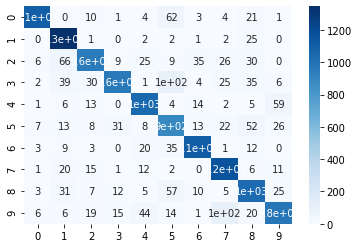

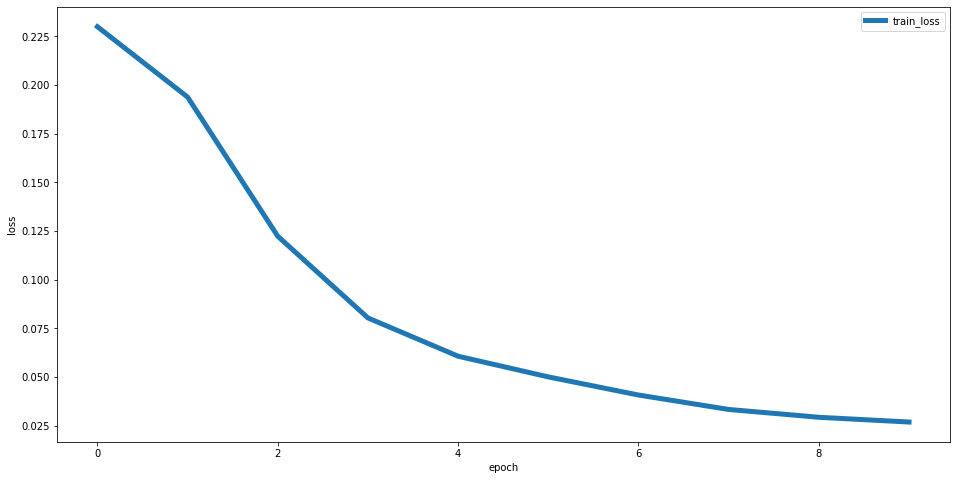

In [90]:
evaluate(X_val, y_val, y_val_one_hot, cnn)
plot_learning_curve(cnn.train_loss)